## Information/Vocabulary

``Bag of Words`` - Doesn't take into consideration the order of the words in the sentence, while ``Vector models`` and ``ML`` do.

``Scipy`` - Use instead of `numpy` when matrices are sparse.

``Tokens`` - Items used to represent a sentence: words, subwords, characters.

``Embeddings`` - Vector Representation of Tokens.

``Stemming`` - Chops off the end of the word (may not return a real word).

``Lemmatization`` - Returns the root of the word (**lemma**).

``TF - IDF(t, d)`` = `tf(t, d)` x `idf(t)`, where `t` is the term (token) and `d` is document. `tf(t, d)` is the count of term `t` on document `d` (or proportion if one normalizes it), while `idf(t)` = `log(N/N(t))`, where `N` is the number of documents (rows) and `N(t)` is how many of those documents contain term `t`.

If we are ranking scores based on a metric of vectors, it is a good idea to normalize the vectors so that `Euclidian Distance` and `Cosine Distance` give equivalent outputs.

## Code tips

``CountVectorizer`` is a package from ``scikit-learn`` for count embeddings (used mainly for documents):


 - ``CountVectorizer(stop_words="english"/list_predefined)`` - Remove **stop words** in english or from a predefined list. The default is None.

 - ``CountVectorizer(analyzer="word"/"char")`` - Defines the **tokenization** level. Either words or characters.

``nltk`` is a library for **NLP**:
- ``nltk.download('stopwords')`` to download the stopwords module.
- ``stopwords.words(language)`` to get the stopwords of the specific language. See all languages available in ``~/nltk_data/corpora/stopwords/``
- ``PorterStemmer()`` is used to get the Stem of a word.
- ``nltk.download("wordnet")`` to download the ``WordNetLemmatizer`` module, which is used to get the **lemma** of a word.


# Code

## Stemming and Lemmatization

In [2]:
import nltk

In [3]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
print(porter.stem("walking"))
print(porter.stem("walked"))
print(porter.stem("walks"))

walk
walk
walk


In [5]:
print(porter.stem("ran"))
print(porter.stem("run"))
print(porter.stem("running"))

ran
run
run


In [6]:
sentence = "Lemmatization is more sophisticated than stemming"
all_words = sentence.split()

for token in all_words:
    print(porter.stem(token))

lemmat
is
more
sophist
than
stem


In [7]:
print(lemmatizer.lemmatize("walking"))
print(lemmatizer.lemmatize("walking", pos=wordnet.VERB))
print()
print(lemmatizer.lemmatize("going"))
print(lemmatizer.lemmatize("going", pos=wordnet.VERB))

walking
walk

going
go


In [8]:
# Convert parts of speech tags to wordnet tags
def get_wordnet_pos(treebank_tag):
    match treebank_tag[0]:
        case 'J':
            return wordnet.ADJ
        case 'V':
            return wordnet.VERB
        case 'N':
            return wordnet.NOUN
        case 'R':
            return wordnet.ADV
        case _:
            return wordnet.NOUN

In [9]:
sentence = "Donald Trump has a devoted following"
list_words = sentence.split()

# Get the POS tags
words_and_tags = nltk.pos_tag(list_words)
words_and_tags

[('Donald', 'NNP'),
 ('Trump', 'NNP'),
 ('has', 'VBZ'),
 ('a', 'DT'),
 ('devoted', 'VBN'),
 ('following', 'NN')]

In [10]:
for word, tag in words_and_tags:
    lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
    print(lemma)

Donald
Trump
have
a
devote
following


## Count Vectorizer

In [11]:
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [12]:
#for download in ["wordnet", "punkt", "averaged_perceptron_tagger"]:
    #nltk.download(download)

In [13]:
path_to_csv = "data/bbc_text_cls.csv"
df = pd.read_csv(path_to_csv)
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [14]:
inputs = df['text']
labels = df['labels']

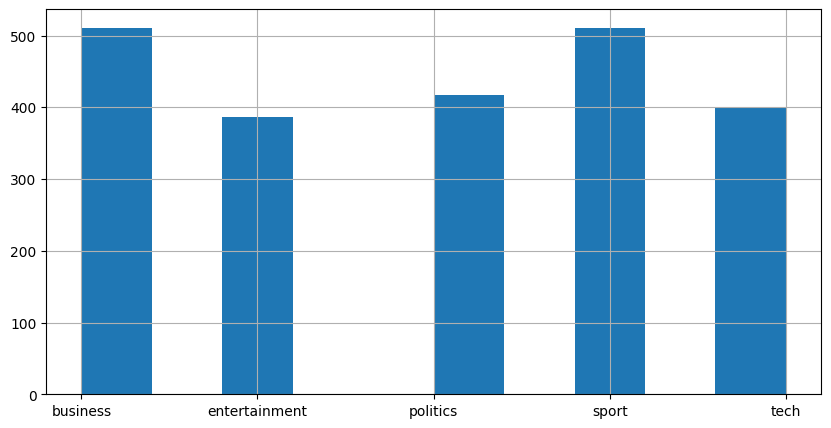

In [15]:
labels.hist(figsize=(10, 5));

In [16]:
# Define lemmatization tokenizer
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
    
lemma_tokenizer = LemmaTokenizer()

In [17]:
# Define stem tokenizer
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(word) for word in tokens]
    
stem_tokenizer = StemTokenizer()

In [18]:
# Initialize Count
vectorizer = CountVectorizer()
vectorizer_stop_words = CountVectorizer(stop_words='english')
vectorizer_lemmatization = CountVectorizer(token_pattern=None, tokenizer=lemma_tokenizer)
vectorizer_stem = CountVectorizer(token_pattern=None, tokenizer=stem_tokenizer)

In [19]:
def process(inputs, labels, vectorizer):
    # Get the data
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=123)
    Xtrain = vectorizer.fit_transform(X_train) # It is now fitted on trainingg
    Xtest = vectorizer.transform(X_test)
    print(f"Number of rows: {Xtrain.shape[0]}")
    print(f"Number of words: {Xtrain.shape[1]}")
    print(f"Number of elements: {np.prod(Xtrain.shape)}")

    # Train model and check performance
    model = MultinomialNB()
    model.fit(Xtrain, y_train)
    print(f"Train score: {(model.score(Xtrain, y_train)*100):.2f}%")
    print(f"Test score:  {(model.score(Xtest, y_test)*100):.2f}%")
    
    return 

In [20]:
# Without removing stop words
print("Normal Vectorizer:\n")
process(inputs, labels, vectorizer)

# Removing stop words
print("\nRemoving Stop words\n")
process(inputs, labels, vectorizer_stop_words)

# Performing Lemmatization
print("\nPerforming Lemmatization\n")
process(inputs, labels, vectorizer_lemmatization)

# Performing Stemming
print("\nPerforming Stemming\n")
process(inputs, labels, vectorizer_stem)

Normal Vectorizer:

Number of rows: 1668
Number of words: 26287
Number of elements: 43846716
Train score: 99.22%
Test score:  97.13%

Removing Stop words

Number of rows: 1668
Number of words: 25995
Number of elements: 43359660
Train score: 99.28%
Test score:  97.67%

Performing Lemmatization

Number of rows: 1668
Number of words: 25894
Number of elements: 43191192
Train score: 99.22%
Test score:  96.77%

Performing Stemming

Number of rows: 1668
Number of words: 22714
Number of elements: 37886952
Train score: 98.92%
Test score:  96.95%


## TF-IDF (Term frequency - Inverse Document Frequency)

In [100]:
import ast
path_to_data = "data/tmdb_5000_movies.csv"
data = pd.read_csv(path_to_data)
data['keywords'] = data['keywords'].apply(ast.literal_eval)
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [101]:
def process_data(data):
    lista = []
    n = data.shape[0]
    keywords = data['keywords']
    for i in range(n):
        lista.append(', '.join([keywords[i][j]['name'] for j in range(len(keywords[i]))]))

    return lista
    
new_data = process_data(data)

In [102]:
X = pd.DataFrame(data = {'name':data['original_title'], 'keywords':new_data})
X['name']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: name, Length: 4803, dtype: object

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

class MovieRecomendation():
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.names_to_idx = {}
        self.names = []

    def fit_transform(self, names, keywords):
        self.names_to_idx = {name: i for i, name in enumerate(names)}
        self.names = names
        new_data = self.vectorizer.fit_transform(keywords)
        return new_data

    def recommend(self, target, data, top_k=5):
        try:
            idx = self.names_to_idx[target]
        except KeyError:
            raise ValueError(f"Index for '{target}' not found in names database")

        movie = data[idx, :]
        normalized_data = normalize(data, axis=1)
        scores = np.dot(normalized_data, movie.T).toarray().ravel()
        scores[idx] = -1 # Mask the movie itself, doesn't make sense to recommend it
        sorted_idx = np.argsort(scores)

        print(f"Recommendations for the movie {target.upper()}:\n")
        for i in range(top_k):
            pos = f"{i+1} th Movie: \n"
            print(pos + names[sorted_idx[-i-1]])
            print()
        
        return 

names = X['name']
keywords = X['keywords']    
movie_to_recommend = "Pirates of the Caribbean: At World's End"

MovieRec = MovieRecomendation()
vectors = MovieRec.fit_transform(names, keywords)
MovieRec.recommend(movie_to_recommend, vectors)

Recommendations for the movie PIRATES OF THE CARIBBEAN: AT WORLD'S END:

1 th Movie: 
Pirates of the Caribbean: Dead Man's Chest

2 th Movie: 
Pirates of the Caribbean: The Curse of the Black Pearl

3 th Movie: 
Cutthroat Island

4 th Movie: 
Anna and the King

5 th Movie: 
Two Lovers

